In [1]:
# Optimize Sigma Variation with ShareParameters

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list
#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100 80GB PCIe (id=0), with 80.00 GB available memory

In [4]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [5]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [6]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

In [7]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [8]:
surf1 = surf

surf1.change_resolution(M=12,N=12)

# Generate a Surface Current field for RQA
surf1 = FourierCurrentPotentialField.from_surface(surf1,M_Phi=12,N_Phi=12,sym_Phi=False, I=0, G=G_QA)

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
surf2.G = G_QH

In [9]:
eq_QA.NFP

3

In [10]:
eq_QH.NFP

3

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

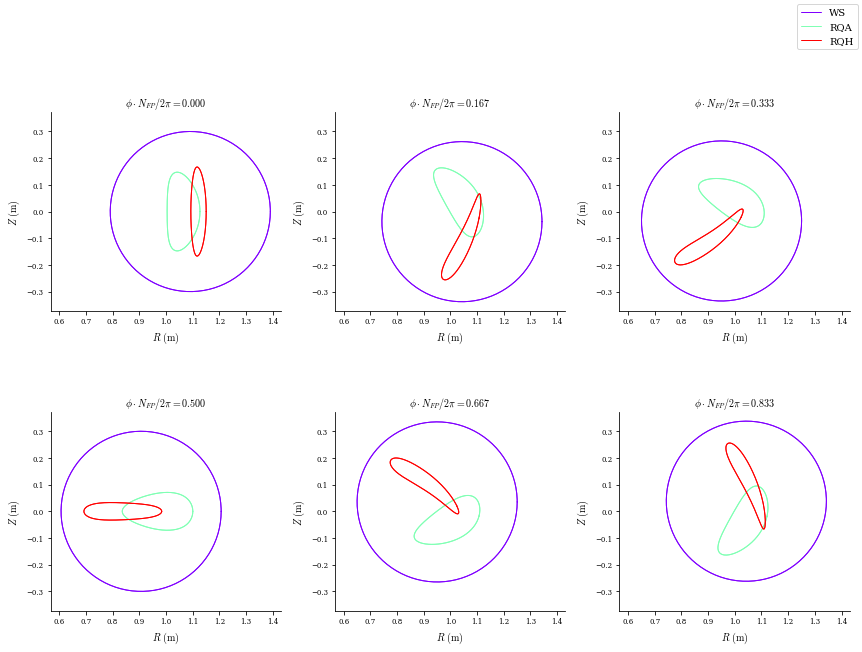

In [11]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [12]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [13]:
# Grids
Megrid = 20
Negrid = 20

Msgrid = 20
Nsgrid = 20

egrid = LinearGrid(M=Megrid,N=Negrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False) 

In [14]:
flux_QA = QuadraticFlux(eq_QA,surf1,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,surf2,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QH")

In [15]:
obj = ObjectiveFunction((flux_QA,
                         flux_QH,
                        )
                       )
constraints = (
    FixParameters(surf1,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
    FixParameters(surf2,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
) # fix the secular parts as well
                        
opt = Optimizer("lsq-exact")

(surf1, surf2), _ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=20,
                                 ftol = 0,#1e-8,
                                 gtol = 0,#1e-8,
                                 xtol = 0,#1e-8,
                                 options={"initial_trust_radius":np.inf})


Building objective: Bn error  eq_QA

Precomputing transforms

Timer: Precomputing transforms = 1.26 sec

Building objective: Bn error  eq_QH

Precomputing transforms

Timer: Precomputing transforms = 43.4 ms

Timer: Objective build = 1.73 sec

Building objective: fixed parameters

Building objective: fixed parameters

Timer: Objective build = 227 ms

Timer: Linear constraint projection build = 3.93 sec

Number of parameters: 1250

Number of objectives: 3362

Timer: Initializing the optimization = 5.97 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          3.073e+02                                    2.083e-03   

/home/fcastro/DESC/desc/optimize/least_squares.py:346: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


       1              2          4.533e-08      3.073e+02      5.753e+05      1.390e-13   

       2              4          4.533e-08      7.741e-19      8.772e-06      1.378e-13   

       3              5          4.533e-08      1.327e-18      1.745e-05      1.353e-13   

       4              6          4.533e-08      2.633e-18      3.462e-05      1.304e-13   

       5              7          4.533e-08      5.351e-18      6.866e-05      1.209e-13   

       6              9          4.533e-08      2.192e-18      3.315e-05      1.166e-13   

       7             10          4.533e-08      4.828e-18      6.670e-05      1.085e-13   

       8             11          4.533e-08      9.011e-18      1.357e-04      9.373e-14   

       9             12          4.533e-08      1.616e-17      2.824e-04      7.003e-14   

      10             13          4.533e-08      2.648e-17      6.077e-04      4.360e-14   

      11             14          4.533e-08      3.805e-17      1.376e-03      1.847e-14   

      12             15          4.533e-08      4.525e-17      3.355e-03      7.057e-15   

      13             17          4.533e-08      1.542e-17      1.768e-03      4.898e-15   

      14             18          4.533e-08      2.192e-17      4.006e-03      3.132e-15   

      15             19          4.533e-08      2.917e-17      9.499e-03      1.652e-15   

      16             20          4.533e-08      3.789e-17      2.271e-02      9.942e-16   

      17             21          4.533e-08      4.750e-17      5.137e-02      4.829e-16   

      18             23          4.533e-08      1.849e-17      2.545e-02      4.294e-16   

      19             24          4.533e-08      2.903e-17      5.305e-02      3.296e-16   

      20             25          4.533e-08      4.359e-17      1.088e-01      2.384e-16   

         Current function value: 4.533e-08

         Total delta_x: 5.753e+05

         Iterations: 20

         Function evaluations: 25

         Jacobian evaluations: 21

Timer: Solution time = 40.8 sec

Timer: Avg time per step = 1.94 sec

                                                                 Start  -->   End

Total (sum of squares):                                      3.073e+02  -->   4.533e-08, 

Maximum absolute Boundary normal field error:                3.501e-02  -->   2.627e-08 (T m^2)

Minimum absolute Boundary normal field error:                3.129e-17  -->   2.000e-12 (T m^2)

Average absolute Boundary normal field error:                1.035e-02  -->   4.241e-09 (T m^2)

Maximum absolute Boundary normal field error:                3.169e-01  -->   2.378e-07 (normalized)

Minimum absolute Boundary normal field error:                2.832e-16  -->   1.810e-11 (normalized)

Average absolute Boundary normal field error:                9.372e-02  -->   3.839e-08 (normalized)

Maximum absolute Boundary normal field error:                7.879e-02  -->   2.256e-06 (T m^2)

Minimum absolute Boundary normal field error:                3.296e-17  -->   1.488e-16 (T m^2)

Average absolute Boundary normal field error:                2.717e-02  -->   3.080e-07 (T m^2)

Maximum absolute Boundary normal field error:                1.383e+00  -->   3.959e-05 (normalized)

Minimum absolute Boundary normal field error:                5.784e-16  -->   2.611e-15 (normalized)

Average absolute Boundary normal field error:                4.768e-01  -->   5.404e-06 (normalized)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

In [16]:
surf1.NFP

3

Text(0.5, 1.0, 'Phi surf2')

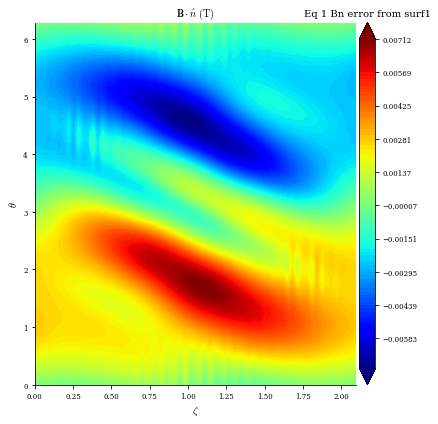

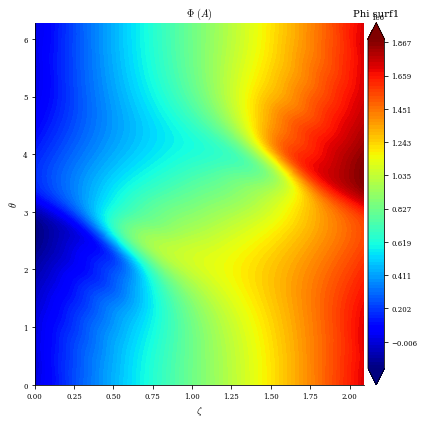

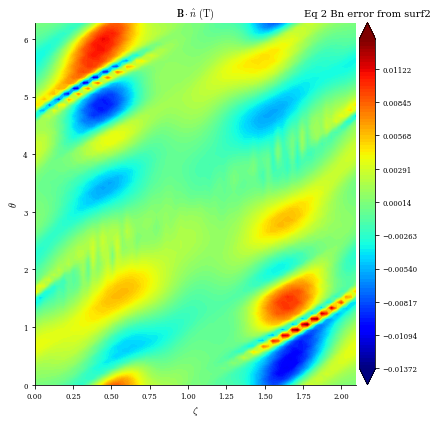

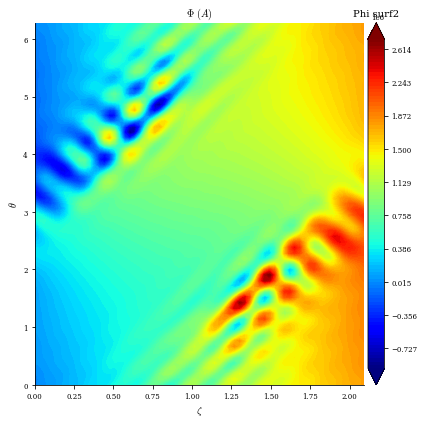

In [17]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=40,N=40,
                                #NFP=eq_QA.NFP
                               )
plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "Phi")
plt.title("Phi surf1")


plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")
plot_2d(surf2, "Phi")
plt.title("Phi surf2")

In [18]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [19]:
# Distance target
min_QA = 0.08
max_QA = 0.25

min_QH = 0.08
max_QH = 0.25

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 2.5,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf1,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 3.5,
    name="distance error  RQH"
)

In [20]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-np.inf,-7),
    weight=1e0,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [21]:
obj = ObjectiveFunction((#flux_QA,
                         #flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         obj_mean_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_sigma_QA,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    #FixParameters(surf2,{"G":True,}),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [22]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [23]:
# Run optimization
(surf1, surf2),_ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=40,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 options={"initial_trust_radius":np.inf})

Building objective: distance error  RQA

Precomputing transforms

Timer: Precomputing transforms = 126 ms

Building objective: distance error  RQH

Precomputing transforms

Timer: Precomputing transforms = 29.8 ms

Building objective: Mean curvature

Precomputing transforms

Timer: Precomputing transforms = 35.3 ms

Timer: Objective build = 260 ms

Building objective: shared parameters

Timer: Objective build = 5.12 ms

Timer: Linear constraint projection build = 2.42 sec

Number of parameters: 1879

Number of objectives: 5043

Timer: Initializing the optimization = 2.76 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          2.409e+03                                    5.017e+03   

       1              3          2.094e+03      3.153e+02      4.189e-02      1.777e+03   

       2              4          2.012e+03      8.134e+01      3.220e-02      1.091e+03   

       3              5          1.961e+03      5.082e+01      2.496e-02      1.022e+03   

       4              6          1.921e+03      4.035e+01      1.536e-02      1.137e+03   

       5              7          1.892e+03      2.860e+01      1.140e-02      1.279e+03   

       6              8          1.866e+03      2.654e+01      1.018e-02      1.604e+03   

       7              9          1.840e+03      2.586e+01      9.011e-03      1.529e+03   

       8             10          1.813e+03      2.667e+01      9.993e-03      1.920e+03   

       9             11          1.788e+03      2.534e+01      8.044e-03      1.718e+03   

      10             12          1.763e+03      2.529e+01      9.048e-03      2.104e+03   

      11             13          1.739e+03      2.335e+01      7.060e-03      1.834e+03   

      12             14          1.719e+03      2.029e+01      7.440e-03      4.463e+03   

      13             15          1.707e+03      1.239e+01      4.065e-03      7.402e+03   

      14             16          1.699e+03      7.658e+00      3.607e-03      7.629e+03   

      15             17          1.689e+03      1.032e+01      3.529e-03      7.454e+03   

      16             18          1.681e+03      7.265e+00      3.896e-03      8.385e+03   

      17             19          1.671e+03      1.075e+01      3.464e-03      8.175e+03   

      18             20          1.664e+03      6.739e+00      3.762e-03      1.027e+04   

      19             21          1.655e+03      8.944e+00      2.703e-03      1.235e+04   

      20             22          1.649e+03      5.647e+00      1.215e-03      5.737e+03   

      21             23          1.646e+03      3.444e+00      2.543e-03      1.212e+04   

      22             24          1.640e+03      5.924e+00      1.052e-03      5.065e+03   

      23             25          1.637e+03      2.751e+00      2.896e-03      1.491e+04   

      24             26          1.630e+03      7.056e+00      9.278e-04      5.020e+03   

      25             27          1.626e+03      3.779e+00      2.215e-03      1.117e+04   

      26             28          1.622e+03      3.946e+00      9.188e-04      6.559e+03   

      27             29          1.620e+03      2.556e+00      1.963e-03      1.291e+04   

      28             30          1.615e+03      4.382e+00      8.298e-04      6.046e+03   

      29             31          1.613e+03      2.202e+00      2.084e-03      1.434e+04   

      30             32          1.609e+03      4.654e+00      7.453e-04      5.937e+03   

      31             33          1.607e+03      1.942e+00      2.036e-03      1.502e+04   

      32             34          1.602e+03      4.583e+00      6.957e-04      5.817e+03   

      33             35          1.600e+03      1.714e+00      1.984e-03      1.548e+04   

      34             36          1.596e+03      4.373e+00      6.283e-04      6.216e+03   

      35             37          1.594e+03      2.220e+00      1.263e-03      1.036e+04   

      36             38          1.592e+03      2.223e+00      6.247e-04      7.202e+03   

      37             39          1.590e+03      1.586e+00      1.278e-03      1.277e+04   

      38             40          1.587e+03      2.640e+00      5.792e-04      7.320e+03   

      39             42          1.586e+03      1.448e+00      4.569e-04      2.186e+03   

      40             43          1.583e+03      2.681e+00      1.099e-03      3.481e+03   

         Current function value: 1.583e+03

         Total delta_x: 1.832e-01

         Iterations: 40

         Function evaluations: 43

         Jacobian evaluations: 41

Timer: Solution time = 31.7 sec

Timer: Avg time per step = 774 ms

                                                                 Start  -->   End

Total (sum of squares):                                      2.409e+03  -->   1.583e+03, 

Maximum Plasma-vessel distance:                              3.257e-01  -->   2.690e-01 (m)

Minimum Plasma-vessel distance:                              8.101e-02  -->   3.262e-02 (m)

Average Plasma-vessel distance:                              2.011e-01  -->   1.427e-01 (m)

Maximum Plasma-vessel distance:                              3.169e+00  -->   2.618e+00 (normalized)

Minimum Plasma-vessel distance:                              7.883e-01  -->   3.174e-01 (normalized)

Average Plasma-vessel distance:                              1.957e+00  -->   1.389e+00 (normalized)

Maximum Plasma-vessel distance:                              3.097e-01  -->   2.430e-01 (m)

Minimum Plasma-vessel distance:                              6.063e-02  -->   2.146e-02 (m)

Average Plasma-vessel distance:                              1.994e-01  -->   1.402e-01 (m)

Maximum Plasma-vessel distance:                              3.235e+00  -->   2.538e+00 (normalized)

Minimum Plasma-vessel distance:                              6.333e-01  -->   2.241e-01 (normalized)

Average Plasma-vessel distance:                              2.083e+00  -->   1.465e+00 (normalized)

Maximum Mean curvature:                                     -4.018e-01  -->   1.433e+00 (m^-1)

Minimum Mean curvature:                                     -2.264e+00  -->  -6.361e+00 (m^-1)

Average Mean curvature:                                     -1.621e+00  -->  -2.690e+00 (m^-1)

Maximum Mean curvature:                                     -1.205e-01  -->   4.300e-01 (normalized)

Minimum Mean curvature:                                     -6.791e-01  -->  -1.908e+00 (normalized)

Average Mean curvature:                                     -4.862e-01  -->  -8.069e-01 (normalized)

Shared parameters error:                                     0.000e+00  -->   1.159e-13 (~)

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

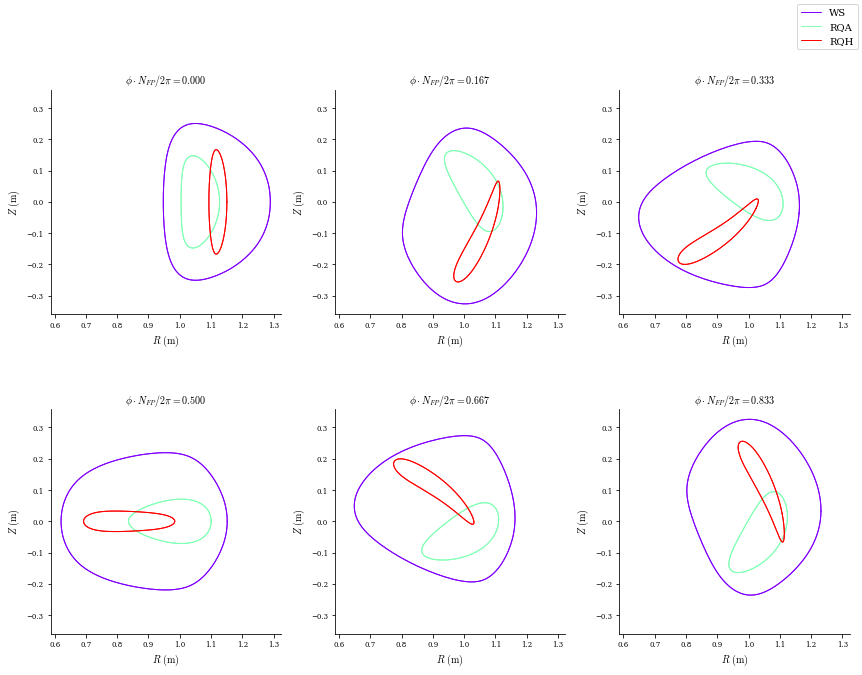

In [24]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [25]:
surf1.save("surf_opt.h5")